In [1]:
import os 
import json
import pandas as pd
from utils import do_pca, do_tsne
import matplotlib.pyplot as plt


In [2]:
meta = {
    "dset_path": "/home/mantydze/data/ZeroBias2017B/massaged/chargeInner_PXLayer_1.csv",
    "dset_name": "ZeroBias",
    "dset_era": "2017B",
    "histo_name": "chargeInner_PXLayer_1",
    
    "good": [{"run_number": 297050, "exclude": [420, 421, 424, 426, 429]}, 
             {"run_number": 297056, "exclude": [31, 34, 36, 40]}, 
             {"run_number": 297178, "exclude": [675, 678, 680, 683, 1266, 1378]}, 
             {"run_number": 297359, "include": [39, 43, 45, 180]}
            ],
    "bad": [{"run_number": 297047}, {"run_number": 297048}, 
            {"run_number": 297170}, {"run_number": 297171}, 
            {"run_number": 297281}, {"run_number": 297284}, 
            {"run_number": 297286}, {"run_number": 297664}, 
            {"run_number": 297671}, {"run_number": 297672}, 
            {"run_number": 297050, "include": [420, 421, 424, 426, 429]}, 
            {"run_number": 297056, "include": [31, 34, 36, 40]}, 
            {"run_number": 297178, "include": [675, 678, 680, 683, 1266, 1378]}]
}

In [3]:
import math

def show_hist(df, cmap_name="Oranges"):
    
    cmap = plt.get_cmap(cmap_name)
    
    plt.figure(figsize=(20,10))
    
    nrows = df.shape[0]
    
    if nrows == 0:
        print("zero rows")
        return
    color_step = 1.0/nrows
    label_step = math.ceil(nrows/30.0)
    
    title_set = False
    
    for index, row in df.sort_values(['lumi']).iterrows():
        if not title_set:
            plt.title("{} Run {}".format(row["hname"], row["run"]))
            title_set = True
        
        data = [row[col]/row["entries"] for col in row.keys() if 'bin_' in col]
        data = data[1:-1]
        
        color_index = row["lumi"] * color_step
        
        label = row["lumi"] if row["lumi"] % label_step == 0 else ""
        
        plt.plot(range(len(data)), data, c=cmap(color_index), label=label)
        
    plt.legend()

In [4]:
def get_data(df, meta, verbose=False, cmap_name="Oranges"):
    
    condition = None
    
    for row in meta:
        
        sub_condition = None
        
        if "include" in row:
            sub_condition = df["run"] == row["run_number"] & df["lumi"].isin(row["include"])
            
        if "exclude" in row:
            sub_condition = (df["run"] == row["run_number"]) & ~df["lumi"].isin(row["exclude"])
        
        if "include" in row and "exclude" in row:
            sub_condition = (df["run"] == row["run_number"]) & ~df["lumi"].isin(row["exclude"]) & df_orig["lumi"].isin(row["include"])
        
        if sub_condition is None:
            sub_condition = df["run"] == row["run_number"]
        
        if verbose:
            print("Sub")
            print(sub_condition.value_counts())
            
        show_hist(df[sub_condition], cmap_name=cmap_name)
        
        if condition is None:
            condition = sub_condition
        else:
            condition = condition | sub_condition
        
        if verbose:
            print("Condition")
            print(condition.value_counts())
    
    return df[condition].copy()

In [5]:
# Read dataset
df_orig = pd.read_csv(meta["dset_path"])

# Drop empty rows
df_orig.drop(df_orig[df_orig.entries == 0].index, inplace=True)

# Drop garbage
df_orig.drop(["Unnamed: 0", "Unnamed: 0.1", "fromrun.1", "fromlumi.1", "hname.1"], axis=1, inplace=True, errors="ignore")

df_orig.shape

(27208, 115)

### Train data

zero rows
(2324, 116)
zero rows
zero rows
zero rows
(282, 116)


(2606, 116)

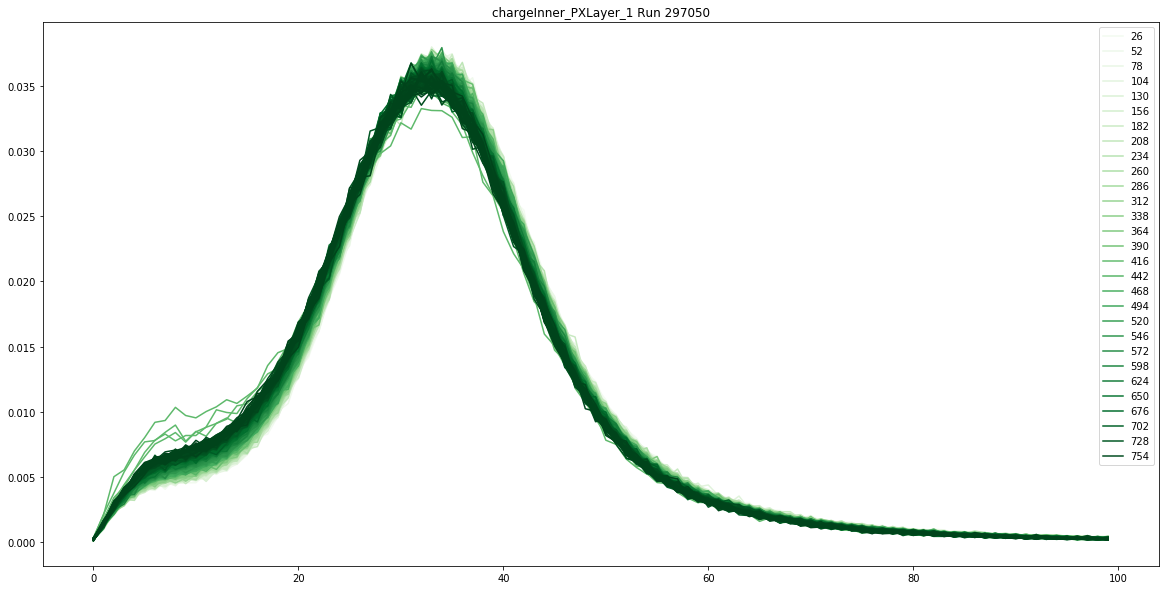

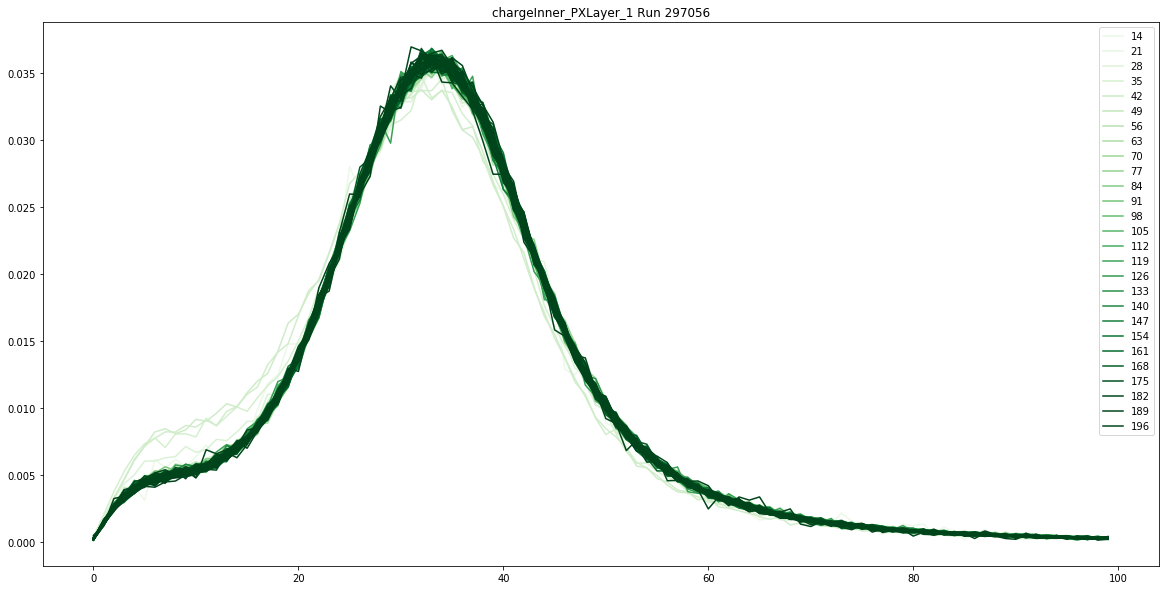

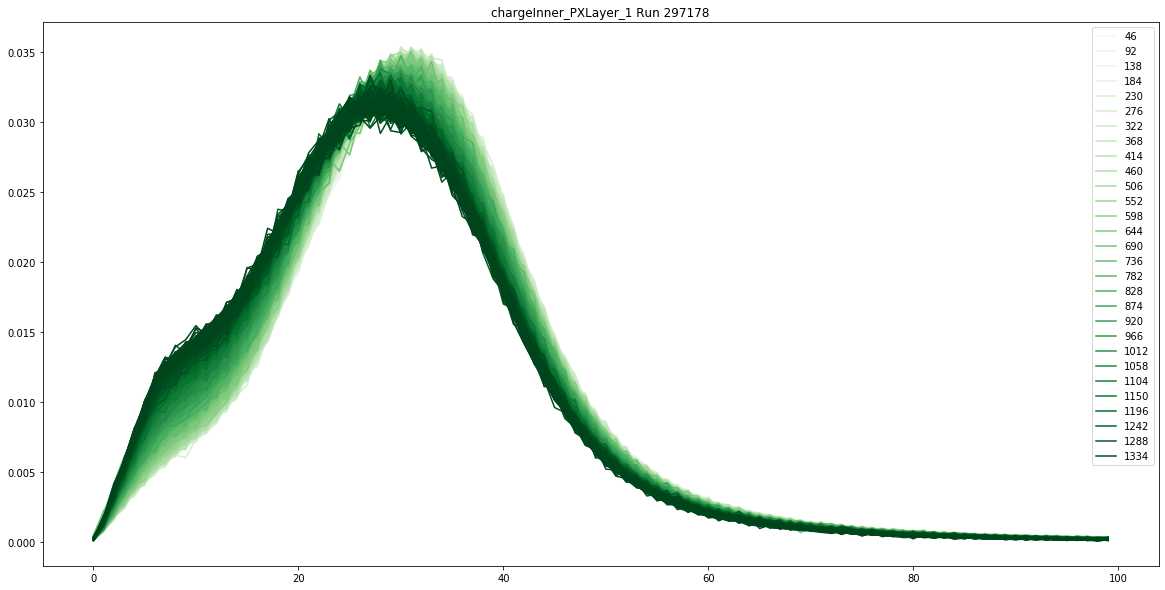

<Figure size 1440x720 with 0 Axes>

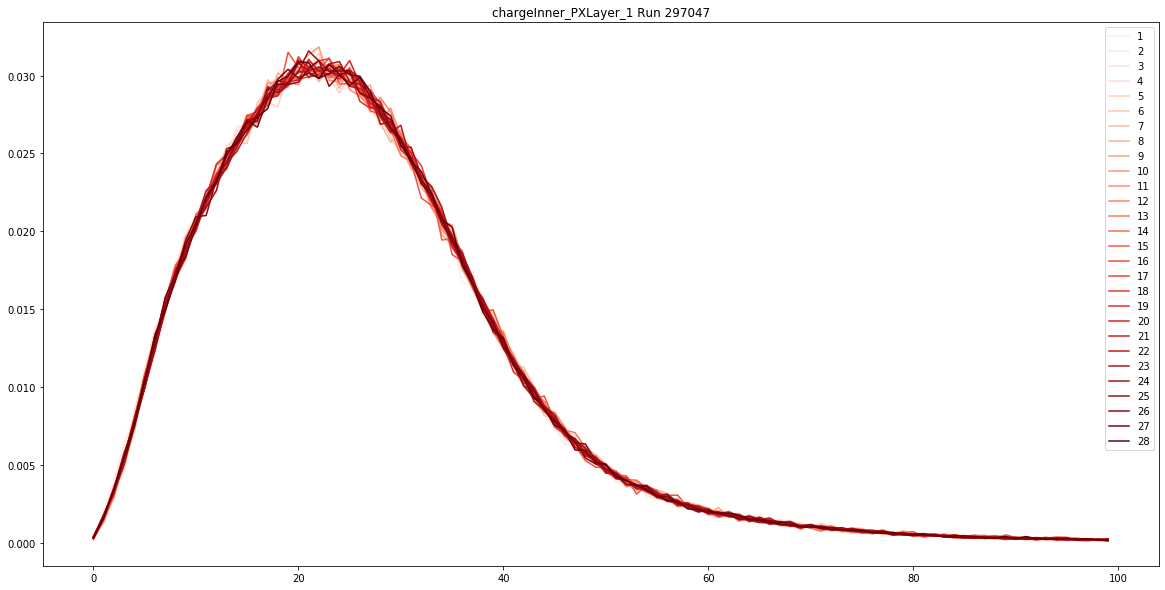

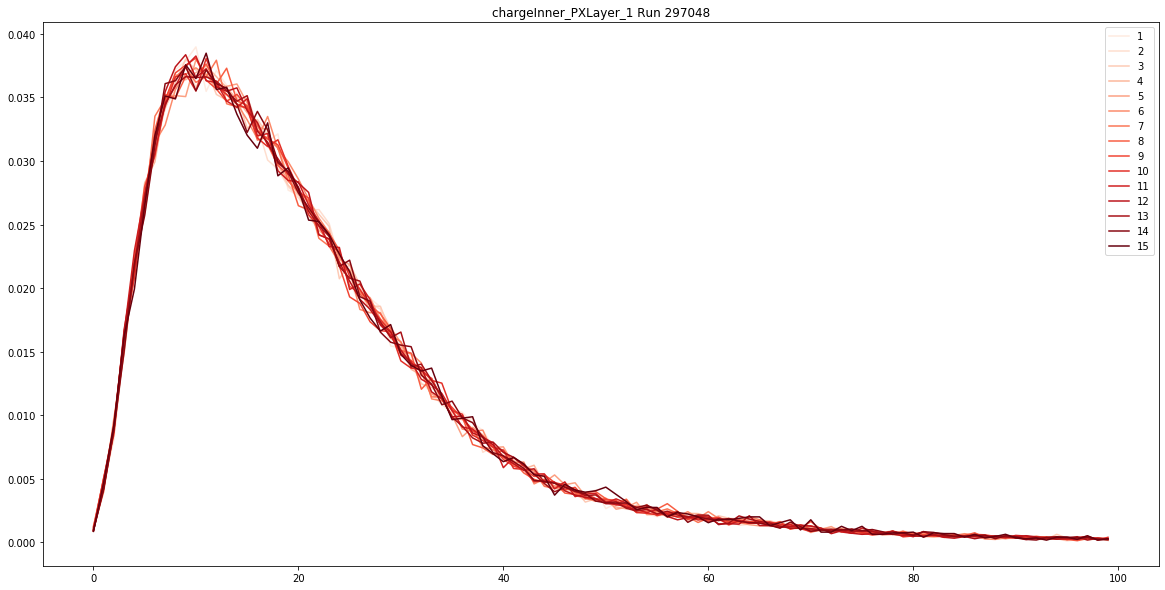

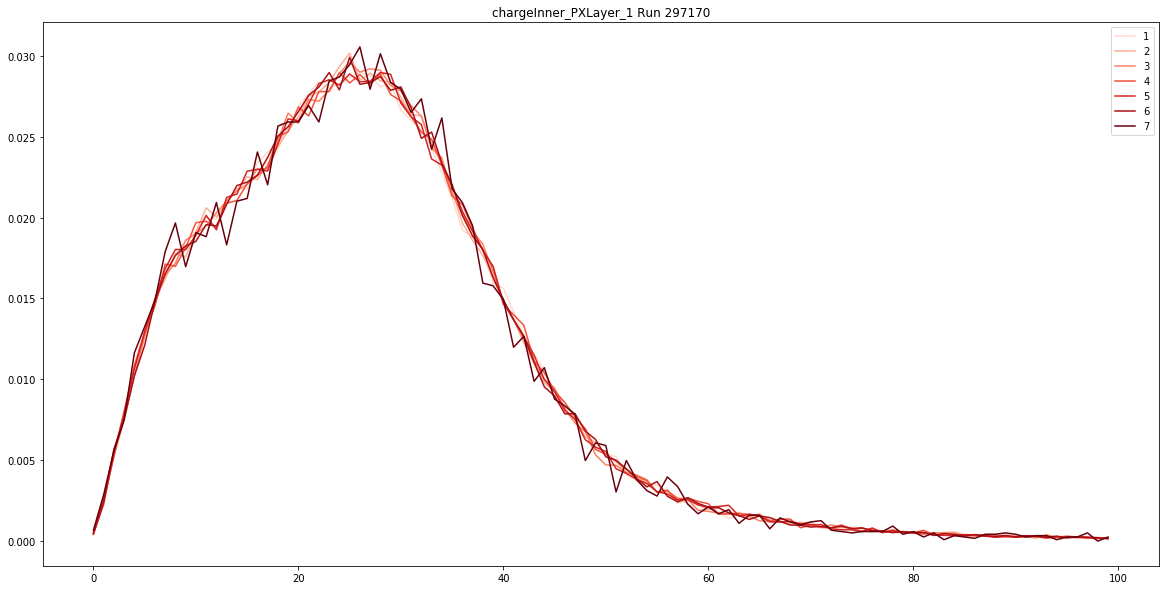

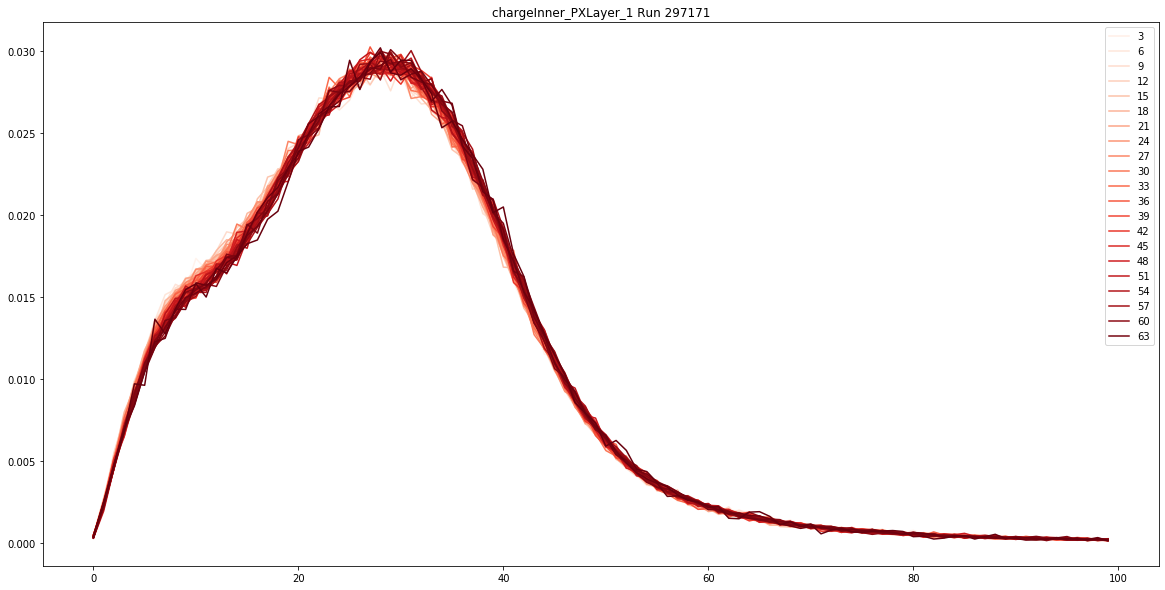

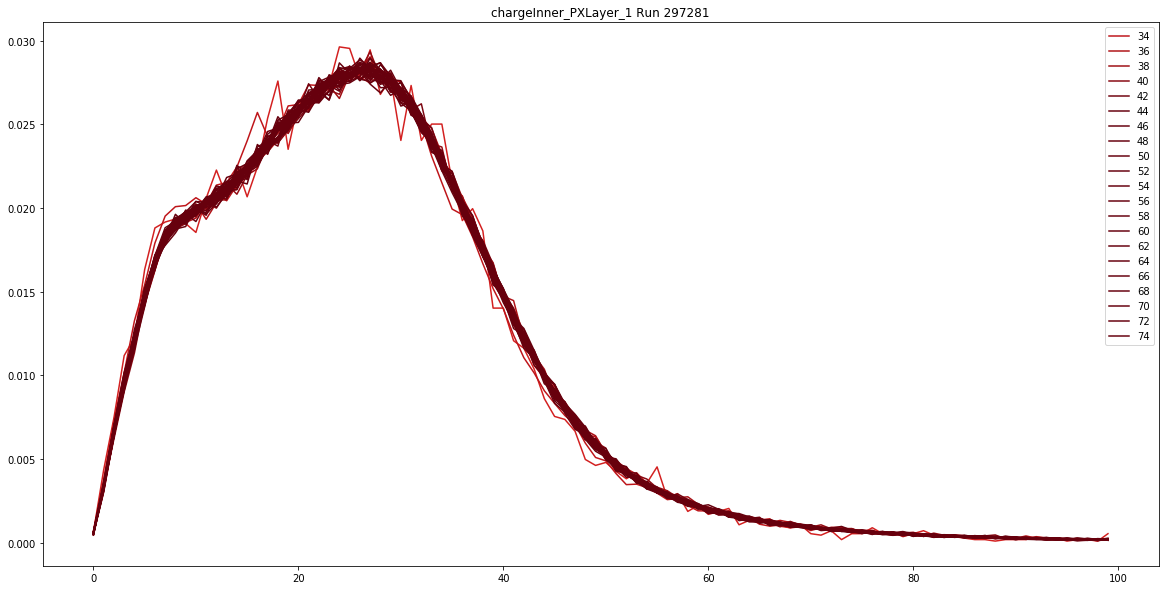

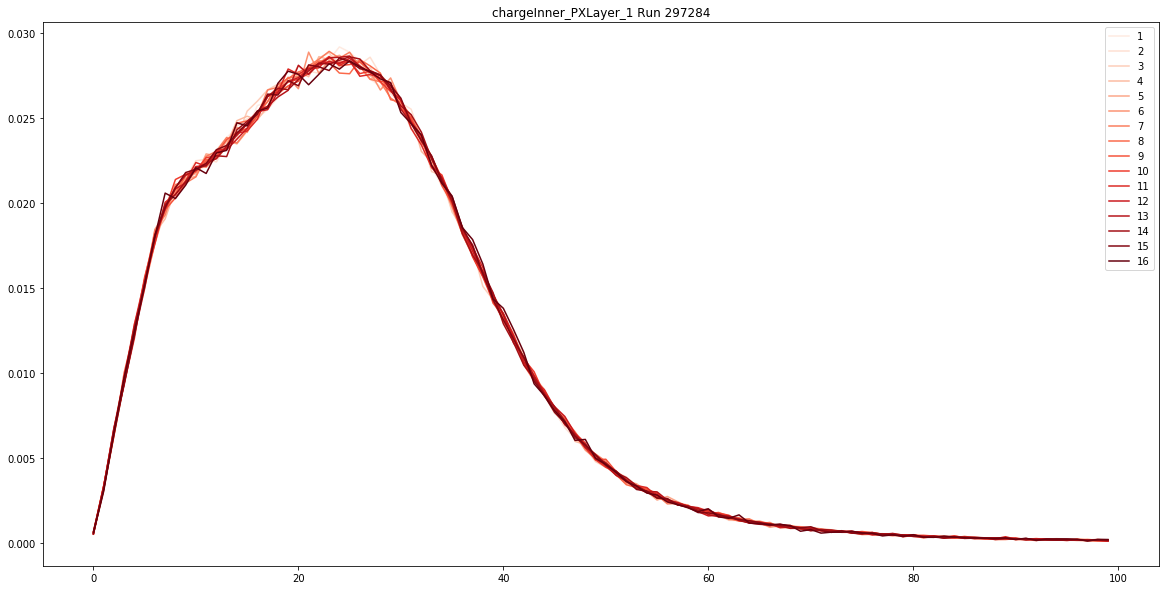

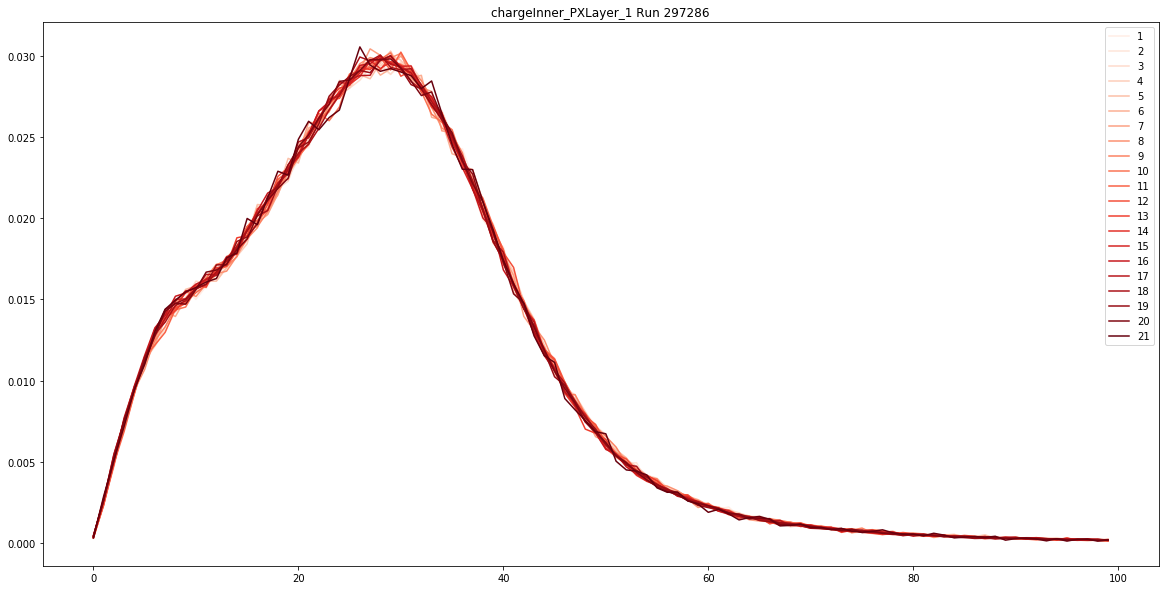

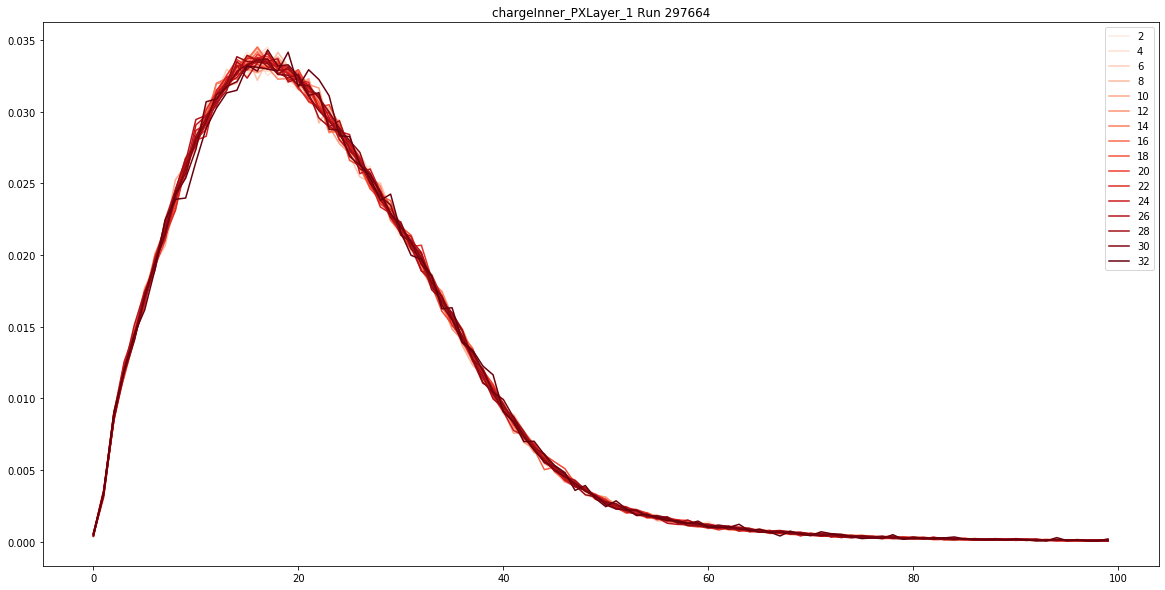

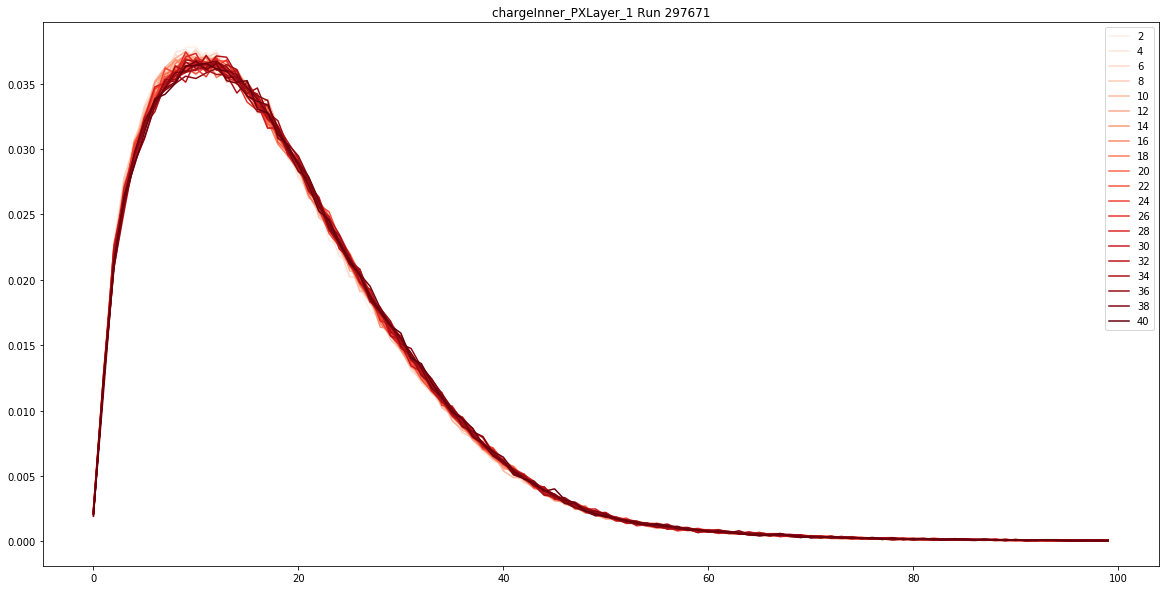

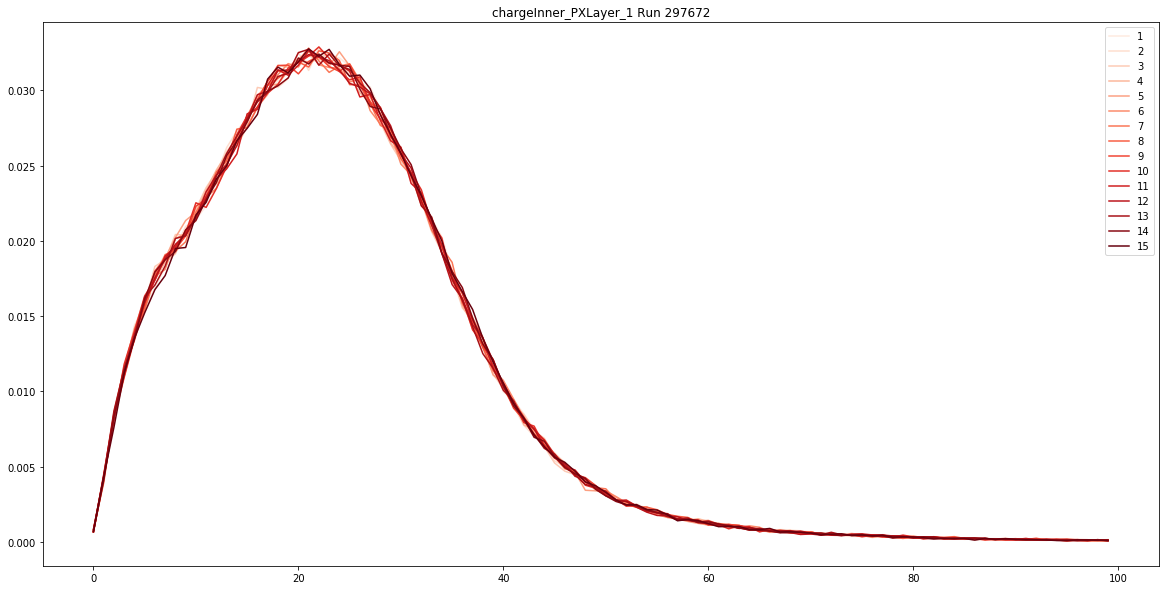

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [6]:
# GOOD
df_good = get_data(df_orig, meta["good"], cmap_name="Greens")
df_good['y'] = 1
print(df_good.shape)

# BAD
df_bad = get_data(df_orig, meta["bad"], cmap_name="Reds")
df_bad['y'] = 0
print(df_bad.shape)

df_train = pd.concat([df_good, df_bad], ignore_index=True)
df_train.to_csv("train.csv")

df_train.shape

### Test data (original dataset without handpicked GOOD and BAD histograms)

In [7]:
exclude_runs = list(df_good["run"].unique()) + list(df_bad["run"].unique())
df_test = df_orig[~df_orig["run"].isin(exclude_runs)].copy()

df_test.to_csv("test.csv")

df_test.shape

(24587, 115)

Explained variance ratio [0.89516432 0.09171519 0.00397091 0.00129648]


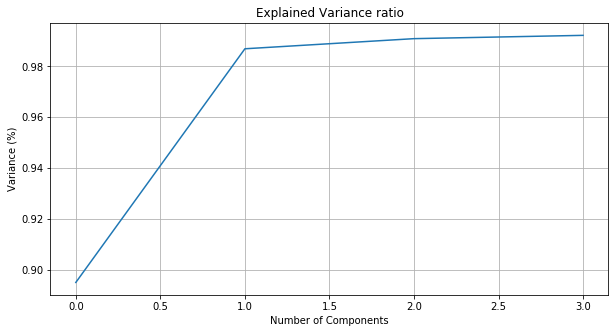

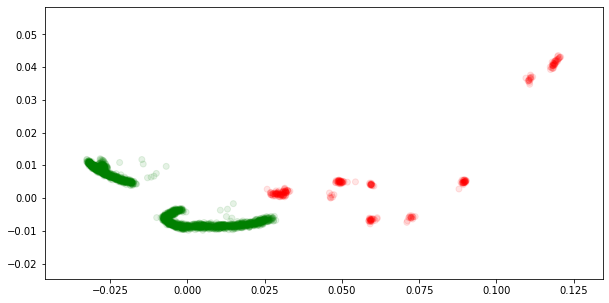

In [8]:
do_pca(df_train)

In [9]:
# raise

Explained variance ratio [0.78660887 0.18682721 0.00511073 0.00406371]


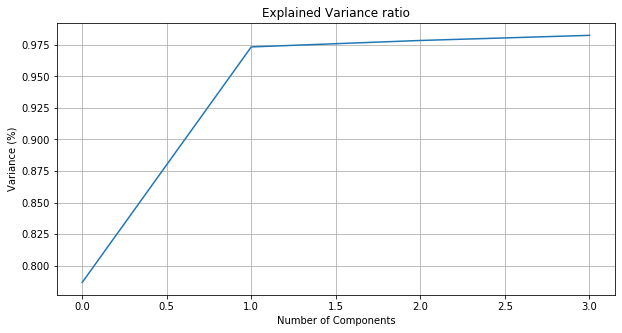

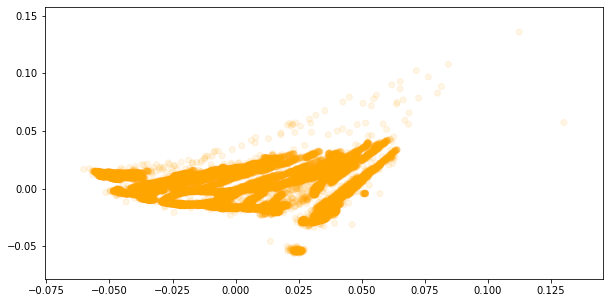

In [10]:
df_test["y"] = 2
do_pca(df_test)

Explained variance ratio [0.78890036 0.18589028 0.00520835 0.00392304]


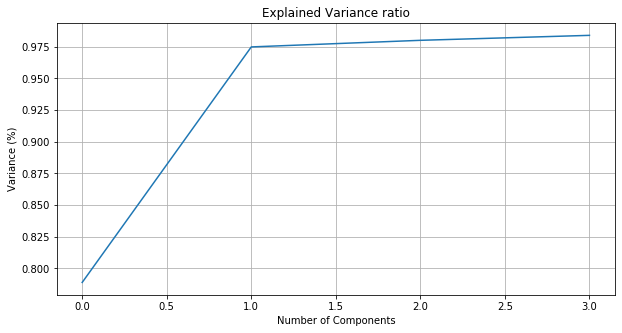

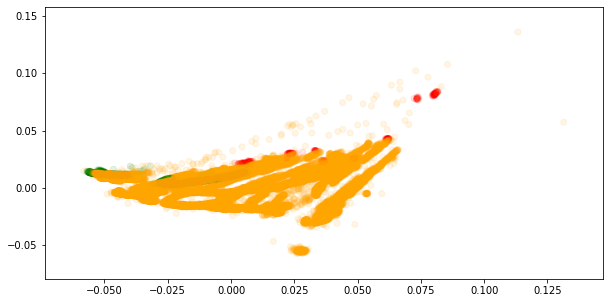

In [11]:
do_pca(pd.concat([df_train, df_test], ignore_index=True))

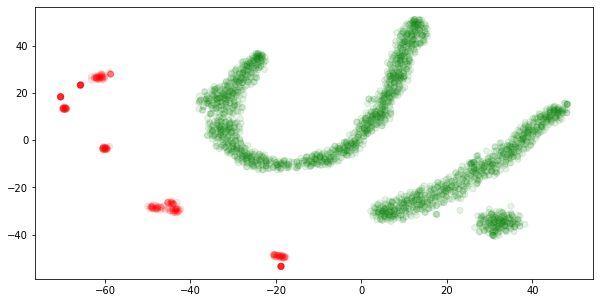

In [12]:
do_tsne(df_train)

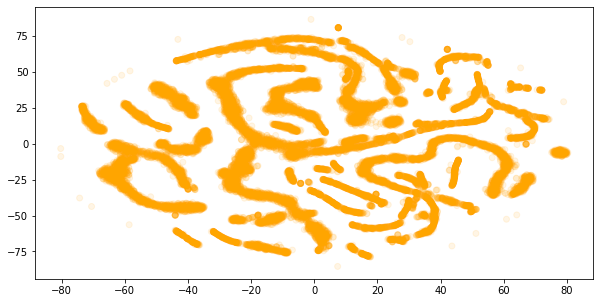

In [13]:
do_tsne(df_test)

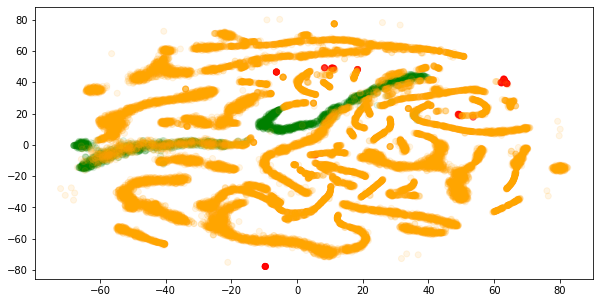

In [14]:
do_tsne(pd.concat([df_train, df_test], ignore_index=True))